In [1]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns


In [3]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.feature_bagging import FeatureBagging

In [4]:
# reading the dataset
df = pd.read_csv("rca.csv")

<AxesSubplot:xlabel='latency', ylabel='source'>

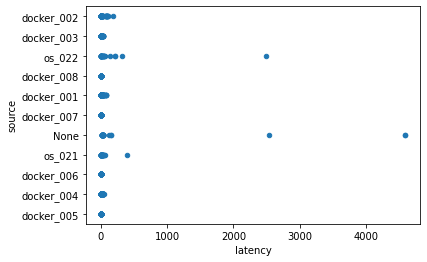

In [5]:
df.plot.scatter('latency', 'source')

In [6]:
le = preprocessing.LabelEncoder()
le.fit(df['source'])
LabelEncoder()
list(le.classes_)
sourceTransformed = le.transform(df['source'])

In [7]:
X1 = df['latency'].values.reshape(-1,1)
X2 = sourceTransformed.reshape(-1,1)

print(X1)
print(X2)

X = np.concatenate((X1,X2), axis=1)

[[ 4]
 [ 2]
 [ 2]
 ...
 [ 1]
 [14]
 [ 0]]
[[5]
 [5]
 [5]
 ...
 [7]
 [1]
 [1]]


In [8]:
# le = preprocessing.LabelEncoder()
# test = pd.DataFrame(df.source)
# sourceTransformed = le.fit_transform(test.values)


# X1 = df.latency.values.reshape(-1,1)
# X2 = sourceTransformed.reshape(-1,1)

# print(X1)
# print(X2)

# X = np.concatenate((X1,X2), axis=1)

In [9]:
outliers_fraction = 0.1
# Test 4 different methods
classifiers = {
        'FeatureBagging': FeatureBagging(contamination=outliers_fraction),
        'KNN': KNN(contamination=outliers_fraction),
        'HBOS': HBOS(contamination=outliers_fraction),
        'IForest': IForest(contamination=outliers_fraction)
}

OUTLIERS :  192 INLIERS :  1908 FeatureBagging


C:\Users\licen\AppData\Local\Temp\ipykernel_17296\3238029372.py:28: UserWarning: No contour levels were found within the data range.
  subplot.contour(xx, yy, Z, levels = [threshold], linewidths=2, colors='red')
C:\Users\licen\AppData\Local\Temp\ipykernel_17296\3238029372.py:31: UserWarning: No contour levels were found within the data range.
  subplot.contour(xx, yy, Z, levels=[threshold, Z.max()], colors='blue')


OUTLIERS :  98 INLIERS :  2002 KNN
OUTLIERS :  3 INLIERS :  2097 HBOS


C:\Users\licen\AppData\Local\Temp\ipykernel_17296\3238029372.py:27: UserWarning: No contour levels were found within the data range.
  subplot.contour(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 15))
C:\Users\licen\AppData\Local\Temp\ipykernel_17296\3238029372.py:28: UserWarning: No contour levels were found within the data range.
  subplot.contour(xx, yy, Z, levels = [threshold], linewidths=2, colors='red')
C:\Users\licen\AppData\Local\Temp\ipykernel_17296\3238029372.py:31: UserWarning: No contour levels were found within the data range.
  subplot.contour(xx, yy, Z, levels=[threshold, Z.max()], colors='blue')


OUTLIERS :  209 INLIERS :  1891 IForest


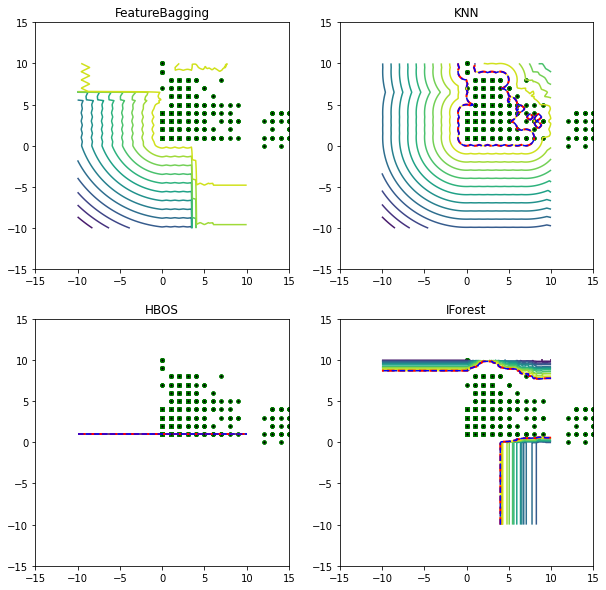

In [10]:
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))
plt.figure(figsize=(10, 10))

for i, (clf_name, clf) in enumerate (classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
    print(scores_pred)

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    y_pred

    
    np.unique(y_pred, return_counts=True)
    
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

    outliers = []
    for index in range(len(y_pred)): # returns the total record list discriminated by outlier and inlier
        #print(index)
        if y_pred[index] == 1:
            outliers.append(index)

    print(outliers)

    outliersList = df.iloc[outliers,:]
    outliersList
    # outliers.sort()
    # outliers
    # outliersList.count()

    # threshold value to consider a datapoint inlier or outlier - the probability that the prediction is true
    threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    # plot outliers and contour
    subplot = plt .subplot(2, 2, i + 1)
    subplot.contour(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 15))
    subplot.contour(xx, yy, Z, levels = [threshold], linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contour(xx, yy, Z, levels=[threshold, Z.max()], colors='blue')

    # scatter plot of inliers with white dots
    subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white', s=12, edgecolor='g')
    # scatter plot of outliers with black dots
    subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='black', s=12, edgecolor='g')
    subplot.axis('tight')

    subplot.set_title(clf_name)
    subplot.set_xlim((-15, 15))
    subplot.set_ylim((-15, 15))
plt.show()
